In [112]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from transformers import AutoTokenizer, DistilBertModel
import numpy as np
import matplotlib.pyplot as plt

In [113]:
# create a simple torch model with 1 fully connected layer

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 2)

    def forward(self, x):
        # apply relu on the output of the fully connected layer
        # x = F.relu(self.fc1(x))
        x = self.fc1(x)
        return x

In [114]:
color_words = [
    'aqua', 'aquamarine', 'azure', 'beige', 'bisque',
    'chartreuse', 'chocolate', 'coral', 'crimson', 'cyan', 'firebrick', 'fuchsia',
    'gold', 'gray', 'indigo', 'ivory', 'khaki', 'lavender', 'lime', 'magenta',
    'maroon', 'navy', 'olive', 'orchid', 'plum', 
    'salmon', 'sienna', 'silver', 'tan', 'teal', 'tomato', 'turquoise', 
    'wheat', 'sienna', 'ochre', 'umber', 'sepia', 'vermillion',
    'carmine', 'cerulean', 'auburn', 'viridian', 'ultramarine', 'emerald'
]

most_common_color_words = [
    'red', 'green', 'blue', 'yellow', 'orange', 'purple', 'brown', 'pink', 'violet', 'white', 'black'
]

# remove duplicates
color_words = list(set(color_words))
most_common_color_words = list(set(most_common_color_words))

print(len(color_words))
print(len(most_common_color_words))

assert len(list(set(color_words + most_common_color_words))) == len(color_words) + len(most_common_color_words)

43
11


In [115]:
non_color_words = [
    "dog", "cat", "house", "car", "book", "computer", "table", "chair", "tree", "river",
    "song", "movie", "friend", "family", "phone", "city", "food", "drink", "shoe", "hat",
    "jacket", "pen", "paper", "cloud", "sun", "moon", "star", "road", "bridge", "key",
    "lock", "door", "window", "mirror", "clock", "lamp", "flower", "bird", "fish", "ship",
    "plane", "train", "bus", "child", "adult", "student", "teacher", "doctor", "engineer",
    "artist", "writer", "singer", "actor", "politician", "lawyer", "doctor", "patient",
    "dream", "memory", "idea", "emotion", "love", "hate", "fear", "joy", "anger", "hope",
    "doubt", "peace", "war", "freedom", "justice", "truth", "lie", "friendship", "loneliness",
    "success", "failure", "wealth", "poverty", "nature", "technology", "culture", "history",
    "science", "religion", "politics", "economy", "society", "language", "knowledge", "wisdom"
]

# remove duplicates
non_color_words = list(set(non_color_words))

print(len(non_color_words))


91


In [116]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

In [117]:
# create a function that takes a list of words and returns a list of embeddings
def get_embeddings(words):
    embeddings = []

    for word in words:
        input_ids = torch.tensor(tokenizer.encode(word)).unsqueeze(0)
        outputs = model(input_ids)
        last_hidden_states = outputs[0]
        embeddings.append(torch.mean(last_hidden_states[0][1:-1], dim=0).tolist())
    
    assert len(embeddings) == len(words)
    return embeddings

color_embeddings = get_embeddings(color_words)
most_common_color_embeddings = get_embeddings(most_common_color_words)
non_color_embeddings = get_embeddings(non_color_words)

In [118]:
# slice the lists into training and test sets
color_words_train = color_words[:int(len(color_words)*0.8)]
color_words_test = color_words[int(len(color_words)*0.8):]
color_embeddings_train = color_embeddings[:int(len(color_embeddings)*0.8)]
color_embeddings_test = color_embeddings[int(len(color_embeddings)*0.8):]

most_common_color_words_train = most_common_color_words[:int(len(most_common_color_words)*0.8)]
most_common_color_words_test = most_common_color_words[int(len(most_common_color_words)*0.8):]
most_common_color_embeddings_train = most_common_color_embeddings[:int(len(most_common_color_embeddings)*0.8)]
most_common_color_embeddings_test = most_common_color_embeddings[int(len(most_common_color_embeddings)*0.8):]

non_color_words_train = non_color_words[:int(len(non_color_words)*0.8)]
non_color_words_test = non_color_words[int(len(non_color_words)*0.8):]
non_color_embeddings_train = non_color_embeddings[:int(len(non_color_embeddings)*0.8)]
non_color_embeddings_test = non_color_embeddings[int(len(non_color_embeddings)*0.8):]

# create a dataframe with the training sets
train_embeddings = color_embeddings_train + most_common_color_embeddings_train + non_color_embeddings_train
df_train = pd.DataFrame(train_embeddings)
# convert the column names to strings
df_train.columns = [str(i) for i in df_train.columns]

df_train['label'] = [1]*len(color_words_train) + [1]*len(most_common_color_words_train) + [0]*len(non_color_words_train)
df_train['word'] = color_words_train + most_common_color_words_train + non_color_words_train

# create a dataframe with the test sets
test_embeddings = color_embeddings_test + most_common_color_embeddings_test + non_color_embeddings_test
df_test = pd.DataFrame(test_embeddings)
# convert the column names to strings
df_test.columns = [str(i) for i in df_test.columns]

df_test['label'] = [1]*len(color_words_test) + [1]*len(most_common_color_words_test) + [0]*len(non_color_words_test)
df_test['word'] = color_words_test + most_common_color_words_test + non_color_words_test

# df_train = pd.DataFrame({
#     'word': color_words_train + most_common_color_words_train + non_color_words_train,
#     'embedding': color_embeddings_train + most_common_color_embeddings_train + non_color_embeddings_train,
#     'label': [1]*len(color_words_train) + [1]*len(most_common_color_words_train) + [0]*len(non_color_words_train)
# })

# df_test = pd.DataFrame({
#     'word': color_words_test + most_common_color_words_test + non_color_words_test,
#     'embedding': color_embeddings_test + most_common_color_embeddings_test + non_color_embeddings_test,
#     'label': [1]*len(color_words_test) + [1]*len(most_common_color_words_test) + [0]*len(non_color_words_test)
# })

# shuffle the dataframes
# df_train = df_train.sample(frac=1).reset_index(drop=True)
# df_test = df_test.sample(frac=1).reset_index(drop=True)

print(df_train[:5])
print(df_train[-5:])
print(df_test[:5])
print(df_test[-5:])

          0         1         2         3         4         5         6  \
0 -0.041678  0.148708 -0.234286 -0.033252  0.494860  0.622115  0.000841   
1 -0.827585 -0.896846  0.254223 -0.193303  0.349100  0.395511  0.112490   
2  0.002040  0.109842 -0.238287 -0.003682  0.469811  0.030721  0.346308   
3  0.385726 -0.074940 -0.140404  0.059326  0.366880  0.120377  0.186069   
4 -0.138055 -0.053237  0.060839  0.007547  0.434347  0.081092  0.252117   

          7         8         9  ...       760       761       762       763  \
0  0.334732 -0.142980 -0.213030  ... -0.058299 -0.062284  0.417793 -0.012300   
1  0.549485 -0.285964 -0.402029  ...  0.291153  0.110757 -0.147386  0.099284   
2  0.237755 -0.071798 -0.390377  ... -0.159584 -0.174967  0.198345 -0.172087   
3  0.305407  0.346098 -0.088989  ... -0.154134 -0.205948  0.394289 -0.059338   
4  0.487236 -0.014518 -0.217729  ...  0.213379 -0.025966  0.354676 -0.184217   

        764       765       766       767  label      word  
0  0.32

In [119]:
class CustomDataset(Dataset):
    def __init__(self, tokenized_texts, labels):
        self.tokenized_texts = torch.tensor(tokenized_texts)
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.tokenized_texts[idx], self.labels[idx]

In [120]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('mps')
device = torch.device('cpu')

In [121]:
def create_dataloaders(df_train, df_test):
  train_dataset = CustomDataset(df_train['embedding'], df_train['label'])
  test_dataset = CustomDataset(df_test['embedding'], df_test['label'])

  train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

  return train_loader, test_loader

In [122]:
def train_model(train_loader):

    # train the model
    net = Net()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.003)

    num_epochs = 100
    net.to(device)

    best_combined_loss = float('inf')

    for epoch in range(num_epochs):
        net.train()
        combined_loss = 0
        for batch in train_loader:
            # get data to GPU if possible
            data = batch[0].to(device=device, dtype=torch.float32)
            data = data.unsqueeze(1)
            targets = batch[1].to(device=device)
            # print(data.shape)
            
            # forward
            scores = net(data)
            loss = criterion(scores, targets)
            combined_loss += loss.item()

            # backward
            optimizer.zero_grad()
            loss.backward()

            # gradient descent or adam step
            optimizer.step()

        if combined_loss < best_combined_loss:
            best_combined_loss = combined_loss
        
        # print initial loss
        # if epoch == 0:
        #     print(f'Initial loss: {combined_loss/len(train_loader)}')
            
        # print average loss per epoch every 10 epochs
        # if (epoch + 1) % 10 == 0:
        #     print(f'Epoch {epoch + 1}, loss={combined_loss/len(train_loader)}')
        #     # print(combined_loss / len(train_loader))

    return net, best_combined_loss



In [123]:
# evaluate the net
def check_accuracy(loader, net):
    num_correct = 0
    num_samples = 0
    net.eval()

    with torch.no_grad():
        for batch in loader:
            # get data to GPU if possible
            data = batch[0].to(device=device, dtype=torch.float32)
            data = data.unsqueeze(1)
            targets = batch[1].to(device=device)

            # forward
            scores = net(data)
            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
    
    return num_correct / num_samples

In [125]:
# go through all the slices of the dataframe and train and evaluate the model

all_test_accs = []
all_combined_losses = []

for slice in range(768):
    print(f'Slice: {slice}')
    # slice = 0

    # create one column slice of the dataframe
    df_train_slice = pd.DataFrame({
        # 'word': df_train['word'],
        'embedding': df_train[str(slice)],
        'label': df_train['label']
    })

    df_test_slice = pd.DataFrame({
        # 'word': df_test['word'],
        'embedding': df_test[str(slice)],
        'label': df_test['label']
    })

    # print(df_train_slice[:5])
    # print(df_train_slice[-5:])

    train_slice_loader, test_slice_loader = create_dataloaders(df_train_slice, df_test_slice)

    # take the best of 3 runs
    best_test_acc = 0

    for i in range(10):
        net, best_combined_loss = train_model(train_slice_loader)

        train_acc = check_accuracy(train_slice_loader, net)
        test_acc = check_accuracy(test_slice_loader, net)

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            # best_train_acc = train_acc
            # best_net = net
    
    all_test_accs.append(best_test_acc)
    all_combined_losses.append(best_combined_loss)

    # print(f'Accuracy on training set: {check_accuracy(train_loader, net)*100:.2f}%')
    # print(f'Accuracy on test set: {check_accuracy(test_loader, net)*100:.2f}%')

    print(f'Slice {slice} best combined loss: {best_combined_loss}')
    print(f'Slice {slice} best test accuracy: {best_test_acc*100:.2f}% \n')

print(len(all_test_accs))

Slice: 0
Slice 0 best combined loss: 4.771129250526428
Slice 0 best test accuracy: 64.52% 

Slice: 1
Slice 1 best combined loss: 4.871202111244202
Slice 1 best test accuracy: 70.97% 

Slice: 2
Slice 2 best combined loss: 4.939927458763123
Slice 2 best test accuracy: 64.52% 

Slice: 3
Slice 3 best combined loss: 4.792909502983093
Slice 3 best test accuracy: 64.52% 

Slice: 4
Slice 4 best combined loss: 4.9441253542900085
Slice 4 best test accuracy: 61.29% 

Slice: 5
Slice 5 best combined loss: 5.047808349132538
Slice 5 best test accuracy: 61.29% 

Slice: 6
Slice 6 best combined loss: 4.953889191150665
Slice 6 best test accuracy: 61.29% 

Slice: 7
Slice 7 best combined loss: 4.838975667953491
Slice 7 best test accuracy: 67.74% 

Slice: 8
Slice 8 best combined loss: 4.7594287395477295
Slice 8 best test accuracy: 67.74% 

Slice: 9
Slice 9 best combined loss: 4.956266850233078
Slice 9 best test accuracy: 61.29% 

Slice: 10
Slice 10 best combined loss: 4.817738354206085
Slice 10 best test ac

In [126]:
print(all_test_accs[:10]) 

[tensor(0.6452), tensor(0.7097), tensor(0.6452), tensor(0.6452), tensor(0.6129), tensor(0.6129), tensor(0.6129), tensor(0.6774), tensor(0.6774), tensor(0.6129)]


In [127]:
# convert list of tensors into list of floats
all_test_accs_val = [acc.item() for acc in all_test_accs]

print(all_test_accs_val[:10])

[0.6451612710952759, 0.7096773982048035, 0.6451612710952759, 0.6451612710952759, 0.6129032373428345, 0.6129032373428345, 0.6129032373428345, 0.6774193644523621, 0.6774193644523621, 0.6129032373428345]


In [133]:
all_test_accs_val = np.array(all_test_accs_val)
all_combined_losses = np.array(all_combined_losses)

In [134]:
# find the indices of the top 10 slices
top_10_indices = np.argsort(all_test_accs_val)[-10:]
print(top_10_indices)
print(all_test_accs_val[top_10_indices])
print(all_combined_losses[top_10_indices])

[ 57 511 685 749 578 645 711 562 588 368]
[0.80645162 0.80645162 0.83870965 0.83870965 0.83870965 0.83870965
 0.83870965 0.83870965 0.87096775 0.87096775]
[4.8475219  4.41397128 3.64875802 4.51245075 4.13233162 4.68023908
 4.66344616 4.57590418 3.90372416 4.17510045]


In [137]:
# create a dataframe with accuracy and loss
df_acc_loss = pd.DataFrame({
    'accuracy': all_test_accs_val,
    'loss': all_combined_losses
})

print(df_acc_loss[:10])

# save the dataframe to a csv file
df_acc_loss.to_csv('llm-outputs/color_bruteforce_acc_loss.csv', index=False)

   accuracy      loss
0  0.645161  4.771129
1  0.709677  4.871202
2  0.645161  4.939927
3  0.645161  4.792910
4  0.612903  4.944125
5  0.612903  5.047808
6  0.612903  4.953889
7  0.677419  4.838976
8  0.677419  4.759429
9  0.612903  4.956267


In [138]:
df_368 = pd.DataFrame({
    'word': df_train['word'],
    'embedding': df_train['368'],
    'label': df_train['label']
})

print(df_368[:5])

df_368.to_csv('llm-outputs/color_bruteforce_368.csv', index=False)

       word  embedding  label
0      plum   0.352192      1
1     umber   0.197500      1
2   emerald   0.047766      1
3  lavender  -0.188735      1
4     sepia  -0.318106      1


In [139]:
df_588 = pd.DataFrame({
    'word': df_train['word'],
    'embedding': df_train['588'],
    'label': df_train['label']
})

print(df_588[:5])

df_588.to_csv('llm-outputs/color_bruteforce_588.csv', index=False)

       word  embedding  label
0      plum   0.073558      1
1     umber  -0.220961      1
2   emerald  -0.171672      1
3  lavender   0.025043      1
4     sepia   0.263970      1


Axis 588 seems to be doing a very good job discerning between colors and non-colors.

In [142]:
# separate the color and non-color embeddings
df_588_color = df_588[df_588['label'] == 1]
df_588_non_color = df_588[df_588['label'] == 0]

# print(df_588_color[:5])
# print(df_588_non_color[:5])

       word  embedding  label
0      plum   0.073558      1
1     umber  -0.220961      1
2   emerald  -0.171672      1
3  lavender   0.025043      1
4     sepia   0.263970      1
      word  embedding  label
42  bridge   0.599472      0
43  friend   0.424847      0
44   doubt   0.525485      0
45  mirror   0.221172      0
46   adult   0.470498      0


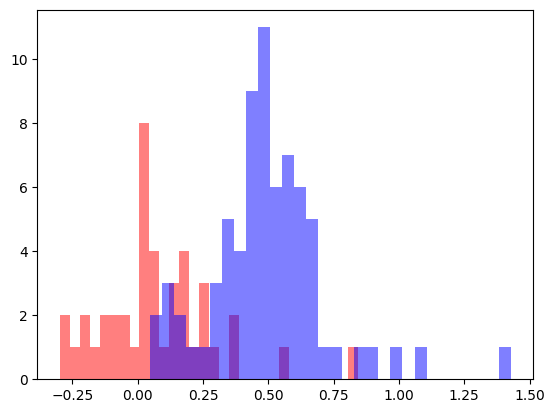

In [147]:
# draw a histogram of the embeddings, with the color words in red and the non-color words in blue
plt.hist(df_588_color['embedding'], bins=30, color='red', alpha=0.5)
plt.hist(df_588_non_color['embedding'], bins=30, color='blue', alpha=0.5)
plt.show()

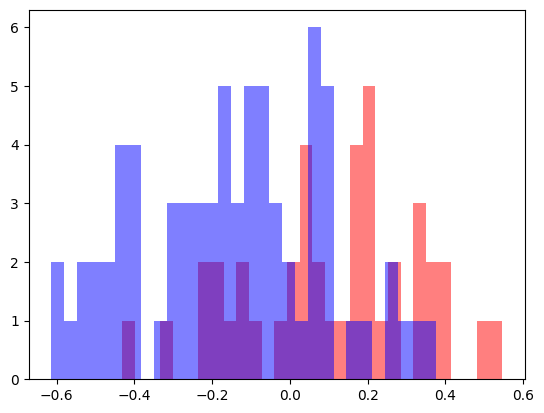

In [149]:
# separate the color and non-color embeddings
df_368_color = df_368[df_368['label'] == 1]
df_368_non_color = df_368[df_368['label'] == 0]

# draw a histogram of the embeddings, with the color words in red and the non-color words in blue
plt.hist(df_368_color['embedding'], bins=30, color='red', alpha=0.5)
plt.hist(df_368_non_color['embedding'], bins=30, color='blue', alpha=0.5)
plt.show()

In [153]:
# for each of the top 10 slices,
# average the embeddings of the color words and the non-color words

color_emb_avg = []
non_color_emb_avg = []

for i in top_10_indices:
    df_slice = pd.DataFrame({
        # 'word': df_train['word'],
        'embedding': df_train[str(i)],
        'label': df_train['label']
    })

    df_slice_color = df_slice[df_slice['label'] == 1]
    df_slice_non_color = df_slice[df_slice['label'] == 0]

    color_emb_avg.append(np.mean(df_slice_color['embedding']))
    non_color_emb_avg.append(np.mean(df_slice_non_color['embedding']))

# create a dataframe with the average embeddings
df_avg = pd.DataFrame({
    'index': top_10_indices,
    'color': color_emb_avg,
    'non_color': non_color_emb_avg,
    'diff': abs(np.array(color_emb_avg) - np.array(non_color_emb_avg))
})

print(df_avg)

# save the dataframe to a csv file
df_avg.to_csv('llm-outputs/color_bruteforce_avg.csv', index=False)

   index     color  non_color      diff
0     57 -0.068853   0.083865  0.152718
1    511  0.096352  -0.060618  0.156970
2    685  0.078926  -0.295794  0.374720
3    749  0.237888   0.044149  0.193739
4    578  0.011691  -0.330732  0.342423
5    645 -0.215030  -0.362590  0.147561
6    711  0.038971  -0.076753  0.115724
7    562  0.252882   0.371339  0.118457
8    588  0.073687   0.495521  0.421835
9    368  0.109949  -0.148048  0.257997


In [159]:
def plot_axis_hist(slice):
    df_slice = pd.DataFrame({
        # 'word': df_train['word'],
        'embedding': df_train[str(slice)],
        'label': df_train['label']
    })

    df_slice_color = df_slice[df_slice['label'] == 1]
    df_slice_non_color = df_slice[df_slice['label'] == 0]

    # draw a histogram of the embeddings, with the color words in red and the non-color words in blue
    plt.hist(df_slice_color['embedding'], bins=30, color='red', alpha=0.5)
    plt.hist(df_slice_non_color['embedding'], bins=30, color='blue', alpha=0.5)
    plt.show()

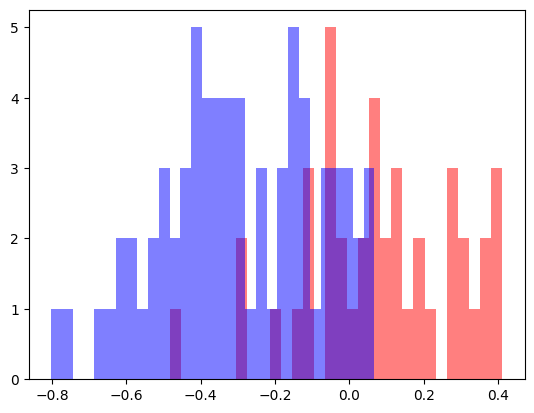

In [160]:
plot_axis_hist(685)

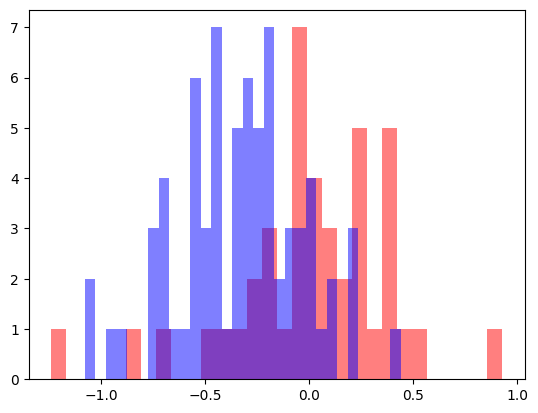

In [161]:
plot_axis_hist(578)